# Physics-Informed Neural Network (PINN) in Julia

This is a simple showcase of how PINNs can learn the solution to (Partial) Differential Equations without labelled data by leveraging automatic differentation to train on a residuum loss of the boundary value problem.

We will consider the 1D Poisson equation
$$
\begin{cases}
\frac{\partial^2 u}{\partial x^2} &= - f(x), \qquad & x \in \Omega = (0, 1)
\\
u(0) &= 0 = u(1)
\end{cases}
$$

For $f(x) = \sin(\pi x)$, the analytical solution is $\hat{u}(x) = \frac{1}{\pi^2} \sin(\pi x)$. We aim to train a shallow neural network to learn the mapping $x \mapsto u$.

This can be done by chosing collocation points, i.e., random points within the domain at which we enfore the PDE. A difference of the neural network against this underlying description will constitute to the loss. Additionally, we will also penalize if the network does not obey the homogeneous Dirichlet boundary conditions. As such our loss is

$$
\mathcal{L} = \alpha_{int} \frac{1}{2N} \sum_{i=1}^N \left( \frac{\partial^2 u}{\partial x^2}\bigg|_{x_i} + f(x_i)  \right)^2  + \alpha_{bc} \frac{1}{2 \cdot 2} \left( u(0)^2 + u(1)^2 \right)
$$

with hyperparameters to weigh the two components of the loss. Our neural network is parameterized by its weights and biases. We can backprop from this loss into the parameter space to obtain a gradient estimate which guides a gradient-based optimizer (here we will use ADAM).

**Julia's reverse-mode automatic differentiation ecosystem, as of now, does not properly support higher-order autodiff**. However, this is crucial, because ultimately we need three autodiff passes, two to get the second derivative within the loss formulation and another one to obtain a gradient estimate in the parameter space.

## Employed architecture

This intro follows the work of Lagaris et al. ([https://arxiv.org/abs/physics/9705023](https://arxiv.org/abs/physics/9705023)) that use a neural network with **one hidden layer**. By the universal approximation theorem, this is sufficient to capture (almost) any function. Hence, given the hidden layer is chosen large enough, it should also be possible to approximate the solution to the PDE. The forward pass of the network becomes

$$
u = v^T \sigma.(w x + b)
$$

We assume our network to be a scalar-to-scalar map, hence

$$
x \in \R, w \in \R^h, b \in \R^h, v \in \R^h, u \in \R
$$

with $h$ being the size of the hidden dimension.

### Analytical Input-Output derivative

**Our goal is to reduce to only one application of the Julia reverse-mode autodiff engine; the pullback from loss to parameter space.** As such, we want to find hand-coded derivatives for the network architecture in their input-output relation.

We can derive this simple shallow network to get

$$
\begin{aligned}
\frac{\partial u}{\partial x} &= (v \odot w)^T \sigma'(w x + b)
\\
\frac{\partial^2 u}{\partial x^2} &= (v \odot w.^2)^T \sigma''(w x + b)
\\
\frac{\partial^l u}{\partial x^l} &= (v \odot w.^l)^T \sigma^{(l)}(w x + b)
\end{aligned}
$$

### The batched case

For all practical applications, we want to query our network batched, i.e., for multiple inputs at the same time. Following the Julia convention, we will therefore the denote the collection of inputs as $x \in \R^{1 \times N}$ and the collection of outputs as $u \in \R^{1 \times N}$. As such, the forward pass becomes

$$
u = V \cdot \sigma.(W \cdot x .+ b)
$$

with the sizes

$$
x \in \R^{1 \times N}, W \in \R^{h, 1}, b \in \R^h, V \in \R^{1, h}, u \in \R^{1 \times N}
$$

### Properties of the sigmoid

Its higher derivatives can be expressed using the primal output

$$
\begin{aligned}
\sigma(x) &= \frac{1}{1 + e^{-x}}
\\
\sigma' &= \sigma (1 - \sigma)
\\
\sigma'' &= \sigma (1 - \sigma) \left( 1- 2\sigma \right) = \sigma' \left( 1- 2\sigma \right)
\end{aligned}
$$



In [3]:
using Optimisers, Zygote, Plots, Random, Distributions

In [89]:
SEED = 42
N_collocation_points = 50
HIDDEN_DEPTH = 100
LEARNING_RATE = 1e-3
N_EPOCHS = 40_000
BC_LOSS_WEIGHT = 100.0

100.0

In [5]:
rhs_function(x) = sin(π * x)
analytical_solution(x) = sin(π * x) / π^2

analytical_solution (generic function with 1 method)

In [6]:
rng = MersenneTwister(SEED)

MersenneTwister(42)

In [7]:
sigmoid(x) = 1.0 / (1.0 + exp(-x))

sigmoid (generic function with 1 method)

In [80]:
function initialize_parameters()
    # Initialize the weights according to the Xavier Glorot initializer
    uniform_limit = sqrt(6 / (1 + HIDDEN_DEPTH))
    W = rand(
        rng,
        Uniform(-uniform_limit, +uniform_limit),
        HIDDEN_DEPTH,
        1,
    )
    V = rand(
        rng,
        Uniform(-uniform_limit, +uniform_limit),
        1,
        HIDDEN_DEPTH,
    )
    b = zeros(HIDDEN_DEPTH)
    parameters = (; W, V, b)
    return parameters
end

initialize_parameters (generic function with 1 method)

In [78]:
#parameters = (; W, V, b)
methds = [:log10, :direct]


2-element Vector{Symbol}:
 :log10
 :direct

In [38]:
network_forward(x, p) = p.V * sigmoid.(p.W * x .+ p.b)

network_forward (generic function with 1 method)

In [39]:
x_line = reshape(collect(range(0.0, stop=1.0, length=100)), (1, 100))

1×100 Matrix{Float64}:
 0.0  0.010101  0.020202  0.030303  …  0.969697  0.979798  0.989899  1.0

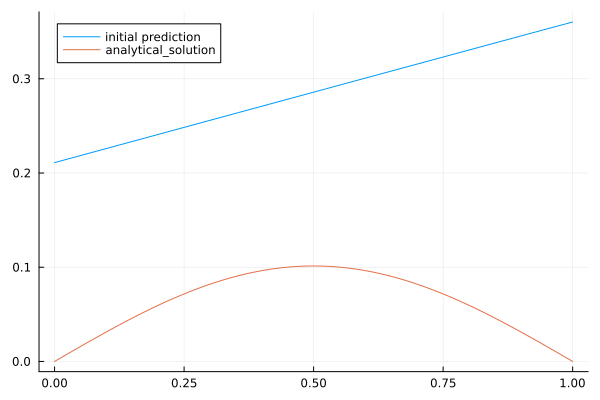

In [40]:
# Plot initial prediction of the network (together with the analytical solution)
plot(x_line[:], network_forward(x_line, parameters)[:], label="initial prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")

In [41]:
function network_output_and_first_two_derivatives(x, p)
    activated_state = sigmoid.(p.W * x .+ p.b)
    sigmoid_prime = activated_state .* (1.0 .- activated_state)
    sigmoid_double_prime = sigmoid_prime .* (1.0 .- 2.0 .* activated_state)

    output = p.V * activated_state
    first_derivative = (p.V .* p.W') * sigmoid_prime
    second_derivative = (p.V .* p.W' .* p.W') * sigmoid_double_prime

    return output, first_derivative, second_derivative
end

network_output_and_first_two_derivatives (generic function with 1 method)

In [14]:
_output, _first_derivative, _second_derivative = network_output_and_first_two_derivatives(x_line, parameters)

([-1.1382941757104061 -1.1380294645870517 … -1.1123972266705167 -1.1121338961386578], [0.026206405934351737 0.026206391767292305 … 0.02607110022899815 0.026068340513950378], [0.0 -2.8050761398991682e-6 … -0.0002718558727582605 -0.0002745673943626082])

In [15]:
_first_derivative

1×100 Matrix{Float64}:
 0.0262064  0.0262064  0.0262063  …  0.0260738  0.0260711  0.0260683

In [16]:
_zygote_first_derivative = Zygote.gradient(x -> sum(network_forward(x, parameters)), x_line)[1]

1×100 Matrix{Float64}:
 0.0262064  0.0262064  0.0262063  …  0.0260738  0.0260711  0.0260683

In [17]:
interior_collocation_points = rand(rng, Uniform(0.0, 1.0), (1, N_collocation_points))

1×50 Matrix{Float64}:
 0.0357248  0.473918  0.441437  0.841032  …  0.872303  0.680714  0.776496

In [18]:
boundary_collocation_points = [0.0 1.0]

1×2 Matrix{Float64}:
 0.0  1.0

In [71]:
function loss_forward_direct(p)
    output, first_derivative, second_derivative = network_output_and_first_two_derivatives(
        interior_collocation_points,
        p,
    )

    interior_residuals = second_derivative .+ rhs_function.(interior_collocation_points)

    interior_loss = 0.5 * mean(interior_residuals.^2)

    boundary_residuals = network_forward(boundary_collocation_points, p) .- 0.0

    boundary_loss = 0.5 * mean(boundary_residuals.^2)

    total_loss = interior_loss + BC_LOSS_WEIGHT * boundary_loss
    return total_loss
end

function loss_forward_log10(p)
    output, first_derivative, second_derivative = network_output_and_first_two_derivatives(
        interior_collocation_points,
        p,
    )

    interior_residuals = second_derivative .+ rhs_function.(interior_collocation_points)

    interior_loss = 0.5 * mean(interior_residuals.^2)

    boundary_residuals = network_forward(boundary_collocation_points, p) .- 0.0

    boundary_loss = 0.5 * mean(boundary_residuals.^2)

    total_loss = interior_loss + BC_LOSS_WEIGHT * boundary_loss
    return log10(total_loss)
end

loss_forward_log10 (generic function with 1 method)

In [72]:
loss_forward_direct(parameters)

28.819199226371428

In [73]:
out, back = Zygote.pullback(loss_forward_direct, parameters)

(28.819199226371428, Zygote.var"#88#89"{Zygote.Pullback{Tuple{typeof(loss_forward_direct), @NamedTuple{W::Matrix{Float64}, V::Matrix{Float64}, b::Vector{Float64}}}, Tuple{Zygote.ZBack{ChainRules.var"#times_pullback2#423"{Float64, Float64}}, Zygote.ZBack{ChainRules.var"#mean_pullback#890"{Int64, ChainRules.var"#sum_pullback#720"{Colon, Matrix{Float64}, ChainRulesCore.ProjectTo{AbstractArray, @NamedTuple{element::ChainRulesCore.ProjectTo{Float64, @NamedTuple{}}, axes::Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}}}}}, Zygote.var"#1942#back#175"{Zygote.var"#171#174"}, Zygote.var"#2006#back#208"{Zygote.var"#204#207"{Zygote.Context{false}, GlobalRef, Matrix{Float64}}}, Zygote.var"#2049#back#227"{Zygote.var"#back#225"{2, 2, Zygote.Context{false}, Int64}}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.broadcasted), typeof(rhs_function), Matrix{Float64}}, Tuple{Zygote.Pullback{Tuple{typeof(Base.Broadcast.broadcastable), Matrix{Float64}}, Tuple{}}, Zygote.var"#2033#back#218"{typeof(identity)}, Zyg

In [74]:
back(1.0)[1]

(W = [1.4803300146372211; 1.5630079556286554; … ; -1.9662345605932028; 0.43855947806799617;;], V = [-39.87913200850759 -36.6141241915767 … -39.7234805267999 -38.98204631027997], b = [3.0821190054503913, 3.239930264863266, 2.5521132444534875, 1.7024225293723152, -3.9284080194665885, -2.5642092985496996, -1.6274292869660414, -0.6108769930917349, 3.2927575924213968, 2.53237857574816  …  2.2878194327121264, 0.19693650320021244, 3.859866103713246, 2.194460486745425, 4.270525492944528, -0.19817573048277912, -2.3096167570258594, -3.234953084261116, -4.090085074748394, 0.909229238222694])

In [75]:
opt = Adam(LEARNING_RATE)

Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8)

In [90]:
loss_history_direct = []
loss_history_log10 = []

for method in methds
    println("Training with method: $method")

if method == :direct
    parameters = initialize_parameters()
    opt_state = Optimisers.setup(opt, parameters)
    for i in 1:N_EPOCHS
        loss, back = Zygote.pullback(loss_forward_direct, parameters)
        push!(loss_history_direct, log10(loss))
        grad, = back(1.0)
        opt_state, parameters = Optimisers.update(opt_state, parameters, grad)
        if i % 100 == 0
            println("Epoch: $i, Loss: $loss")
        end
    end
elseif method == :log10
    parameters = initialize_parameters()
    opt_state = Optimisers.setup(opt, parameters)
    for i in 1:N_EPOCHS
        loss, back = Zygote.pullback(loss_forward_log10, parameters)
        push!(loss_history_log10, loss)
        grad, = back(1.0)
        opt_state, parameters = Optimisers.update(opt_state, parameters, grad)
        if i % 100 == 0
            println("Epoch: $i, Loss: $loss")
        end
    end
end
end

Training with method: log10
Epoch: 100, Loss: -0.6005764341033265
Epoch: 200, Loss: -0.6007304693911208
Epoch: 300, Loss: -0.6008737779393182
Epoch: 400, Loss: -0.6010434933747264
Epoch: 500, Loss: -0.6012377342316525
Epoch: 600, Loss: -0.6014580393951413
Epoch: 700, Loss: -0.6017098597493042
Epoch: 800, Loss: -0.6020039826735658
Epoch: 900, Loss: -0.6023594038710405
Epoch: 1000, Loss: -0.6028090116284063
Epoch: 1100, Loss: -0.6034113179240945
Epoch: 1200, Loss: -0.6042763648739841
Epoch: 1300, Loss: -0.6056282967765948
Epoch: 1400, Loss: -0.6079765588256969
Epoch: 1500, Loss: -0.6127552065458869
Epoch: 1600, Loss: -0.6271411958599825
Epoch: 1700, Loss: -0.6788816358676347
Epoch: 1800, Loss: -0.838389393891607
Epoch: 1900, Loss: -1.1950304662899491
Epoch: 2000, Loss: -1.684066013509283
Epoch: 2100, Loss: -1.819429071617984
Epoch: 2200, Loss: -1.8397917355985367
Epoch: 2300, Loss: -1.8927665299294987
Epoch: 2400, Loss: -1.9374842017641525
Epoch: 2500, Loss: -1.9862133256696528
Epoch: 26

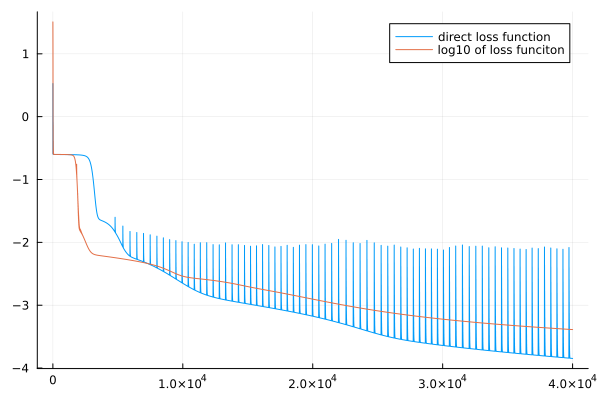

In [91]:
plot(loss_history_direct, label="direct loss function")#, yscale=:log10)
plot!(loss_history_log10, label="log10 of loss funciton")#, yscale=:log10)

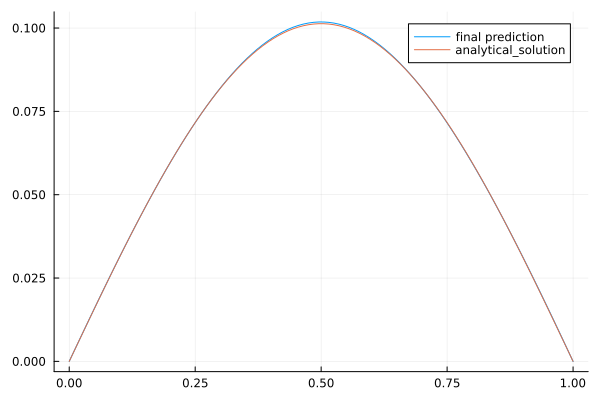

In [26]:
plot(x_line[:], network_forward(x_line, parameters)[:], label="final prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")